In [1]:
import os, sys
import h5py
import numpy as np
import scipy as sp
from astropy import constants as const
import matplotlib.pyplot as plt
import units as un

import yt
from yt.funcs import mylog
mylog.setLevel(40)

%matplotlib notebook
%matplotlib inline

/u/lgaertner/miniconda3/lib/python3.9/_collections_abc.py:684: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]


In [2]:
os.chdir("/u/lgaertner/RUN_DIR/")
%run ~/CODE_DIR/athena/vis/python/plot_mesh.py -i mesh_structure.dat -o mesh.png

In [3]:
os.chdir("/u/lgaertner/RUN_DIR/outputSMRTlong/")
#os.chdir("/u/lgaertner/RUN_DIR/outputSMR/")
print(os.getcwd())

/ccas/u/lgaertner/RUN_DIR/outputSMRTlong


### Check file content

In [4]:
hdf5files = np.sort([f for f in os.listdir(os.getcwd()) if f.endswith(".athdf") and f.startswith("cbd.out1")])
#print(hdf5files)
for f in hdf5files:
    print(f)
    file = h5py.File(f, "r")
    print(file.keys())
    print(file["prim"])
    break

cbd.out1.00000.athdf
<KeysViewHDF5 ['Levels', 'LogicalLocations', 'prim', 'x1f', 'x1v', 'x2f', 'x2v', 'x3f', 'x3v']>
<HDF5 dataset "prim": shape (5, 76, 1, 32, 32), type "<f4">


In [5]:
hdf5files = np.sort([f for f in os.listdir(os.getcwd()) if f.endswith(".athdf") and f.startswith("cbd.out3")])
#print(hdf5files)
for f in hdf5files:
    print(f)
    file = h5py.File(f, "r")
    print(file.keys())
    break

cbd.out3.00000.athdf
<KeysViewHDF5 ['Levels', 'LogicalLocations', 'user_out_var', 'x1f', 'x1v', 'x2f', 'x2v', 'x3f', 'x3v']>


In [6]:
file = h5py.File(hdf5files[0], "r")
print(file.keys())
for key in file.keys():
    print(key, file[key])

<KeysViewHDF5 ['Levels', 'LogicalLocations', 'user_out_var', 'x1f', 'x1v', 'x2f', 'x2v', 'x3f', 'x3v']>
Levels <HDF5 dataset "Levels": shape (76,), type ">i4">
LogicalLocations <HDF5 dataset "LogicalLocations": shape (76, 3), type ">i8">
user_out_var <HDF5 dataset "user_out_var": shape (1, 76, 1, 32, 32), type "<f4">
x1f <HDF5 dataset "x1f": shape (76, 33), type "<f4">
x1v <HDF5 dataset "x1v": shape (76, 32), type "<f4">
x2f <HDF5 dataset "x2f": shape (76, 33), type "<f4">
x2v <HDF5 dataset "x2v": shape (76, 32), type "<f4">
x3f <HDF5 dataset "x3f": shape (76, 2), type "<f4">
x3v <HDF5 dataset "x3v": shape (76, 1), type "<f4">


### Analyse and plot data

In [10]:
#Define the units
mbin = 3. #M_sun
abin = 50. #AU
u = un.units(mbin, abin)
print(1e6/(u.tbin/3.154e7))

30763.91304920987


In [15]:
class data:
    """
    Class to load, analyse and plot HDF5 data
    """
    def __init__(self, prim_files, temp_files = []):
        self.prim_files = prim_files
        self.temp_files = temp_files
        
        self.mbin = u.mbin #M_sun
        self.abin = u.abin #AU
        self.tbin = u.tbin #s
        
        self.rho = []
        self.press = []
        self.v = []
        self.v1 = []
        self.v2 = []
        self.v3 = []
        #self.temp = []
        self.x1s = []
        self.x2s = []
        self.x3s = []
        self.x1p = []
        self.x2p = []
        self.x3p = []
        self.load()
        
        self.v = np.sqrt(np.array(self.v1)**2+np.array(self.v2)**2+np.array(self.v3)**2)
        
        self.kepler = []
        self.cent = np.array([self.x1p,self.x2p]).T
        
        #Centered Kepler, or shifted center
        self.kepler_vel()
        #self.kepler_vel(center=self.cent[85:86], size=0.6)
        
        self.tonp()
        self.temp = self.press/u.presref / (self.rho/u.densref) * u.tempref
        
        self.phi = np.zeros(np.shape(self.rho[0,:,:]))
        self.vr = np.array([])
        self.vphi = np.array([])
        self.polar_vel()
        
    
    def load(self):
        unit_base= {"length_unit":(self.abin,"AU"), "time_unit":(self.tbin,"s"), "mass_unit":(self.mbin,"Msun")}
        """
        for fprim, ftemp in zip(self.prim_files, self.temp_files):
            ds_prim = yt.load(fprim, units_override = unit_base)
            all_data_level_1_prim = ds_prim.covering_grid(level=1, \
                                            left_edge=ds_prim.domain_left_edge, dims=ds_prim.domain_dimensions * 2)
            ds_temp = yt.load(ftemp, units_override = unit_base)
            all_data_level_1_temp = ds_temp.covering_grid(level=1, \
                                            left_edge=ds_temp.domain_left_edge, dims=ds_temp.domain_dimensions * 2)
            rho = all_data_level_1_prim["rho"].in_units("g/cm**3").to_ndarray() # rho is a NumPy array
            press = all_data_level_1_prim["press"].in_units("g/(cm*s**2)").to_ndarray()
            v1 = all_data_level_1_prim["vel1"].in_units("km/s").to_ndarray()
            v2 = all_data_level_1_prim["vel2"].in_units("km/s").to_ndarray()
            v3 = all_data_level_1_prim["vel3"].in_units("km/s").to_ndarray()
            print(ds_prim.field_list)
            temp = all_data_level_1_temp["user_out_var0"].to_ndarray()
            self.rho.append(rho)
            self.press.append(press)
            self.v1.append(v1)
            self.v2.append(v2)
            self.v3.append(v3)
            self.temp.append(temp)
        """
        for fprim in self.prim_files:
            ds_prim = yt.load(fprim, units_override = unit_base)
            all_data_level_1_prim = ds_prim.covering_grid(level=1, \
                                            left_edge=ds_prim.domain_left_edge, dims=ds_prim.domain_dimensions * 2)
            rho = all_data_level_1_prim["rho"].in_units("g/cm**3").to_ndarray() # rho is a NumPy array
            press = all_data_level_1_prim["press"].in_units("g/(cm*s**2)").to_ndarray()
            v1 = all_data_level_1_prim["vel1"].in_units("km/s").to_ndarray()
            v2 = all_data_level_1_prim["vel2"].in_units("km/s").to_ndarray()
            v3 = all_data_level_1_prim["vel3"].in_units("km/s").to_ndarray()
            print(ds_prim.field_list)
            self.rho.append(rho)
            self.press.append(press)
            self.v1.append(v1)
            self.v2.append(v2)
            self.v3.append(v3)            
        #self.load_sink()
        
    def load_sink(self):
        #sink paticle positions
        binary_orbit = np.loadtxt('/u/lgaertner/RUN_DIR/binary_orbit.tab')
        self.x1s = binary_orbit[:,4]
        self.x2s = binary_orbit[:,5]
        self.x3s = binary_orbit[:,6]
        self.x1p = binary_orbit[:,7]
        self.x2p = binary_orbit[:,8]
        self.x3p = binary_orbit[:,9]
        
        self.x1s = np.array(self.x1s)
        self.x2s = np.array(self.x2s)
        self.x3s = np.array(self.x3s)
        self.x1p = np.array(self.x1p)
        self.x2p = np.array(self.x2p)
        self.x3p = np.array(self.x3p)
        
    def tonp(self):
        self.rho = np.array(self.rho)[:,:,:,0]
        self.rho = np.array([r.T for r in self.rho])
        self.press = np.array(self.press)[:,:,:,0]
        self.press = np.array([r.T for r in self.press])
        self.v = np.array(self.v)[:,:,:,0]
        self.v = np.array([v.T for v in self.v])
        self.v1 = np.array(self.v1)[:,:,:,0]
        self.v1 = np.array([v.T for v in self.v1])
        self.v2 = np.array(self.v2)[:,:,:,0]
        self.v2 = np.array([v.T for v in self.v2])
        self.v3 = np.array(self.v3)[:,:,:,0]
        self.v3 = np.array([v.T for v in self.v3])
        #self.temp = np.array(self.temp)[:,:,:,0]
        #self.temp = np.array([v.T for v in self.v3])
        
        
        self.kepler = np.array(self.kepler)
            
    def plot(self, simdata, fname, lab="", scale = 1., height = []):
        if not height:
            height = np.array([np.min(simdata), np.max(simdata)])
        frame = self.abin * 10
        lim = self.abin * 10.*scale
        for filename, data in zip(self.prim_files, simdata):
            
            path = os.path.join(os.getcwd(), 'plots/'+ filename.replace(".athdf", fname))
            fig = plt.figure(figsize=(10,10))
            cmap="plasma"
            ax = fig.add_subplot(111)
            pos = ax.imshow(data, cmap=cmap, vmin=height[0], vmax=height[1], origin='lower', \
                            extent=[-frame,frame,-frame,frame])
            fig.colorbar(pos, ax=ax, label=lab)
            
            #add point on sink particle
            #ax.scatter(*(self.cent[85].T*256/5))
            
            ax.set_aspect('equal', 'box')
            ax.set_xlabel("$x_0~[AU]$")
            ax.set_ylabel("$x_1~[AU]$")
            ax.set_xlim(-lim, lim)
            ax.set_ylim(-lim, lim)
            
            plt.savefig(path)
            plt.close()
        
            
    def kepler_vel(self, center = [], size=15):
        """
        Compute mesh of azimuthal Kepler velocity
        """
        if not np.any(center):
            center = np.array([[0.,0.] for i in range(len(self.rho))])
        
        l = np.shape(self.rho[0])[0]
        for c in center:
            kepler = np.zeros((l, l))
            for i in range(l):
                for j in range(l):
                    x = (20.*i/l-10.-c[0])
                    y = (20.*j/l-10.-c[1])
                    kepler[j,i] = 1/(x**2+y**2)**(1./4)
                    if 1/kepler[j,i]**2 > size: kepler[j,i] = 0.
            kepler[kepler==np.inf] = 0.
            #units
            kepler = kepler*np.sqrt(self.mbin* const.GM_sun / (self.abin *const.au))
            kepler = kepler.to('km/s')
            self.kepler.append(kepler.value)
    
    def polar_vel(self):
        #decompose velocity in radial and azimuthal parts
        
        #compute polar angle on mesh
        l = np.shape(self.phi)[0]
        X = np.array([[i-l/2+1./2 for i in range(l)] for j in range(l)])
        Y = X.T
        
        self.phi = np.arctan2(Y,X)
        
        #compute polar velocity
        self.vr   = self.v1*np.cos(self.phi) + self.v2*np.sin(self.phi)
        self.vphi = -self.v1*np.sin(self.phi) + self.v2*np.cos(self.phi)
        
        

In [27]:
os.chdir("/u/lgaertner/RUN_DIR/outputSMRadiabatic/")
#os.chdir("/u/lgaertner/RUN_DIR/outputSMR/")
print(os.getcwd())
#unit_sys = yt.UnitSystem("disk","20.*AU", "Msun", "Myr")
#yt.unit_system_registry["disk"]
prim = np.sort([f for f in os.listdir(os.getcwd()) if f.endswith(".athdf") and f.startswith("cbd.out1")])
temp = np.sort([f for f in os.listdir(os.getcwd()) if f.endswith(".athdf") and f.startswith("cbd.out3")])

dat = data(prim[-1:])

/ccas/u/lgaertner/RUN_DIR/outputSMRadiabatic
[('athena_pp', 'press'), ('athena_pp', 'rho'), ('athena_pp', 'vel1'), ('athena_pp', 'vel2'), ('athena_pp', 'vel3')]


<ipython-input-15-f0f219b971aa>:165: RuntimeWarning: divide by zero encountered in double_scalars
  kepler[j,i] = 1/(x**2+y**2)**(1./4)


In [28]:
dat.plot(dat.rho, "_rho.png", lab="$\Sigma ~[g/cm^3]$", scale = 1./1)
dat.plot(dat.press, "_press.png", lab="$P ~[g/(cm s^2)]$", scale = 1./3)
dat.plot(dat.temp, "_temp.png", lab="$T ~[K]$", scale = 1./1.)
dat.plot(dat.v, "_vel.png", lab=r"$\|v\|~[km/s]$", scale = 1/1., height=[0.,25.])
dat.plot(dat.vr, "_vel_r.png", lab=r"$v_r~[km/s]$", scale = 1/1., height=[-0.2,0.2])
dat.plot(dat.vphi, "_vel_phi.png", lab=r"$v_\phi~[km/s]$", scale = 1/1., height=[0.,6.])
dat.plot(dat.vphi-dat.kepler, "_vel_phi-kep.png", lab=r"$v_\phi-v_{kepler}~[km/s]$", scale = 1/1., height=[-0.2,0.2])
#dat.plot(dat.kepler, "_kep.png", lab=r"$v_{kepler}~[km/s]$", scale = 1.)
#dat.plot(dat.v-dat.kepler, "_vel-kep.png", lab=r"$\|v\|-v_{kepler}~[km/s]$", scale = 1/9., height=[-15,5])


In [11]:
print(dat.temp.max(), dat.temp.min())

91.52837604013116 14.999999519160285


In [12]:
#check kepler
print(np.array(dat.kepler)[0,256+int(256./10), 256])
print(np.sqrt(dat.mbin* const.GM_sun / (dat.abin *const.au)).to('km/s'))

7.382759387408567
7.295729712875157 km / s


### Disk Mass

In [27]:
mtot = []
print(np.shape(dat.rho))
r = dat.rho[0,int(512/5.):,0] #g/cm^3
print(np.shape(r))
dx = 20./512. * 50.*const.au.to('cm')
dy = 20./512. * 50.*const.au.to('cm')
dz = 1. * 2.*const.au.to('cm')
print(np.mean(r))
mtot.append(np.sum(r))
mav = np.mean(mtot)*dx*dy*dz/(dat.mbin*const.M_sun.to('g'))
print(mav.value)

(1, 512, 512)
(410,)
4.641445069826316e-12
0.008148472731849142


### Initial velocity  and density profile

In [5]:
def vel(rad):
    gm0             = 1.0        #binary mass
    semia           = 1.0        #binary semiaxis
    rsoft           = 0.1*semia  #?
    z               = 0.0        #height
    qrat            = 1.0        #mass ratio (secondary/primary)
    pslope          = -1.0       #?
    dslope          = -0.5       #parameter -p in paper
    p0_over_r0      = 0.01       #squared sound
    p_over_r        = p0_over_r0
    gamma_gas       = 1.0001
    alpha           = 0.1
    
    rad1 = np.sqrt((rad)**2+(rsoft)**2);
    rad2 = np.sqrt((rad)**2+(rsoft)**2+(z)**2);
    qrpl = 0.75*(semia/rad1)**2*qrat/(1.0+qrat)**2;
    vel = np.sqrt((dslope+pslope)*p_over_r + gm0*(rad/rad1)**2/rad1*(1.0+qrpl)+pslope*gm0*(1.0/rad1 -1.0/rad2))
    
    # correct with radial drift due to accretion
    vel_corr = vel- 1.5*p_over_r*gamma_gas*alpha/np.sqrt(gm0/np.sqrt((rad)**2+(rsoft)**2))

    return vel, vel_corr

def density(rad):
    rho0            = 1.0         #from paper
    dslope          = -0.5        #parameter -p in paper
    p0_over_r0      = 0.01        #squared sound speed
    p_over_r        = p0_over_r0
    gm0             = 1.0         #binary mass
    semia           = 1.0         #binary semiaxis
    r0              = semia       #as in paper
    z               = 0.0         #height
    rsoft           = 0.1*semia   #?
    rin             = 2.5         #from input file, R_s in paper
    
    denmid = rho0*(rad/r0)**dslope
    denmid *= np.exp(-(rad/rin)**(-2.0))
    dentem = denmid*np.exp(gm0/p_over_r*(1./np.sqrt((rad)**2+(rsoft)**2+(z)**2)-1./np.sqrt((rad)**2+(rsoft)**2)));
    den = dentem
    return den

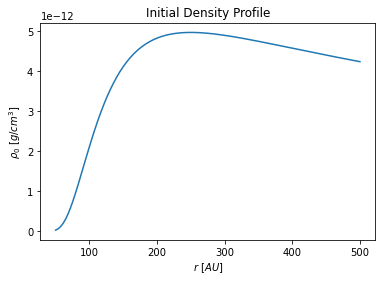

In [14]:
%matplotlib notebook
%matplotlib inline
r = np.linspace(1,10,1000) #computation only out to 10a
plt.plot(r*50.,density(r)*u.densref)
plt.ylabel(r"$\rho_0~[g/cm^3]$")
plt.xlabel("$r~[AU]$")
plt.title("Initial Density Profile")
plt.show()

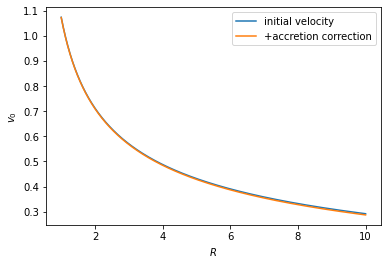

In [20]:

%matplotlib notebook
%matplotlib inline
r = np.linspace(1,10,1000) #computation only out to 10a
v, v_corr = vel(r)
plt.plot(r,v, r, v_corr)
plt.ylabel("$v_0$")
plt.xlabel("$R$")
plt.legend(['initial velocity', '+accretion correction'])
plt.show()

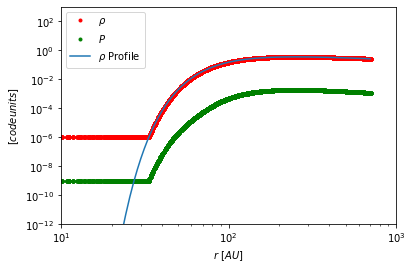

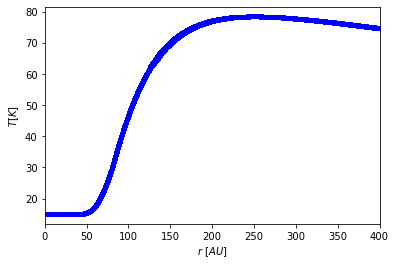

In [26]:

%matplotlib notebook
%matplotlib inline
l = np.shape(dat.rho[0])[0]
rad = np.zeros((l,l))
for i in range(l):
    for j in range(l):
        x = (20.*i/l-10.)
        y = (20.*j/l-10.)
        rad[i,j] = np.sqrt(x**2+y**2)
x = rad.flatten()

q= np.linspace(-10, 10, l)
grid = np.meshgrid(q,q)
rad = np.sqrt(grid[0]**2+grid[1]**2)
x = rad.flatten()*u.abin

R = dat.rho.flatten()/u.densref
P = dat.press.flatten()/u.presref
T = dat.temp.flatten()

r = np.linspace(0.01,14,1000) #computation only out to 10a
rho = density(r)#*densref

plt.loglog(x,R, 'r.')
plt.loglog(x,P, 'g.')
#plt.loglog(x,T, 'b.')
#ax.plot(x,P/R)
plt.loglog(r*u.abin,rho)


plt.xlim([1e1,1e3])
plt.ylim([1e-12,1e3])
plt.ylabel(r"$[code units]$")
plt.xlabel("$r~[AU]$")
plt.legend([r"$\rho$", r"$P$", r"$\rho$ Profile"])

plt.show()

#plt.plot(x,P, 'g.')
plt.plot(x,T, 'b.')

plt.xlim([0,400])
plt.ylabel(r"$T[K]$")
plt.xlabel("$r~[AU]$")

plt.show()

### Initial temperature profile

In [24]:
# Compute initial temp profile

def TempProfileCyl(den0):
    T0 = 15.0 #K
    temp=0
    if(den0*u.densref<1.e-12):
        temp = T0+1.5*1.e13*den0*u.densref
    elif (1.e-12 <= den0*u.densref and den0*u.densref <= 1.e-11):
        temp = (T0+15.)*(den0*u.densref*1.e12)**0.6
    elif (1.e-11 < den0*u.densref and den0*u.densref <= 3.e-9):
        temp = 10**0.6*(T0+15.)*(den0*u.densref*1.e11)**0.44
    return temp


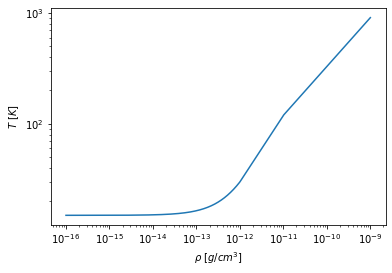

In [25]:
dens = np.logspace(-16, -9, 1000)
tem = [TempProfileCyl(d/u.densref) for d in dens]
plt.loglog(dens, tem, "-")
plt.xlabel(r'$\rho ~[g/cm^3]$')
plt.ylabel(r'$T ~[K]$')
plt.show()

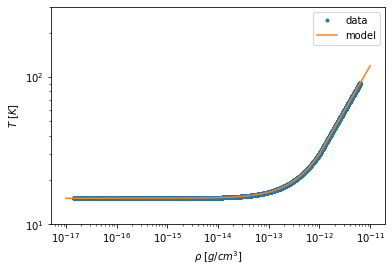

In [26]:

%matplotlib notebook
%matplotlib inline
q=np.linspace(-10, 10, l)
grid = np.meshgrid(q,q)
rad = np.sqrt(grid[0]**2+grid[1]**2)
ra = rad.flatten()

x = []
y = []
for d, t, r in zip(dat.rho[0].flatten(), dat.temp[0].flatten(), rad.flatten()):
    if r > 0:
        x.append(d)
        y.append(t)
plt.loglog(x,y, ".")
plt.xlabel(r'$\rho ~[g/cm^3]$')
plt.ylabel(r'$T ~[K]$')
plt.ylim(10, 3e2)
dens = np.logspace(-17, -11, 1000)
tem = [TempProfileCyl(d/u.densref) for d in dens]
plt.loglog(dens, tem, "-")
plt.legend([r"data", r"model"])
plt.show()

### Find Flooring

In [ ]:
#self.temp = self.press / self.rho * mass_H * mu/k_B
dfloor = 1.e-6
T0 = 15.
pfloor = T0 /u.tempref*dfloor
print(pfloor)